# Aula 05 - KNN, Naive Bayes

Tópicos abordados na aula de hoje:

* Overfit

* Classificador KNN

* Treino - teste - validação

* K-fold Validation

* Naive Bayes

* Matriz de Confusão

* Visualização dos dados

* Train test split

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


## Overfit


Supondo uma relação linear 


$$ \Large y(x) = 3x + 5 $$


Poucos dados, espalhando e com ruido

In [6]:
ruido = 20
n = 20
x = 10 + 5*np.random.randn(n)
y = 3*x + 5 + ruido*np.random.rand(n)

In [7]:
px.scatter(x=x, y=y, height=600)

In [20]:
pol = np.polyfit(x, y, 20)
x_pred_pol = np.linspace(x.min(), x.max(), 1000)
y_pred_pol = np.polyval(pol, x_pred_pol)

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_52880\3344867784.py:1: RankWarning:

Polyfit may be poorly conditioned



In [21]:
lin = np.polyfit(x, y, 1)
x_pred_lin = np.linspace(x.min(), x.max(), 1000)
y_pred_lin = np.polyval(lin, x_pred_lin)

In [22]:
fig = go.Figure()

fig.add_scatter(x=x, y=y, mode='markers')
fig.add_scatter(x=x_pred_pol, y=y_pred_pol)
fig.add_scatter(x=x_pred_lin, y=y_pred_lin)
fig.update(layout_yaxis_range = [-10,80])

## Validação Cruzada

![Cross Validation](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

## k-fold Cross Validation

![5 fold cross validation - sklearn image](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [24]:
ruido = 20
n = 100
x = 10 + 5*np.random.randn(n)
y = 3*x + 5 + ruido*np.random.rand(n)

In [25]:
k = 5
x_k, y_k = [], []
nk = int(n/k)
 
for i in range(k):
    x_k.append(x[i*nk: (i+1)*nk])
    y_k.append(y[i*nk: (i+1)*nk])

In [29]:
x_k[0]

array([11.23993867,  3.64776123, 12.92253269,  7.94438934, 11.4682702 ,
        3.54615026, 11.89816597, 11.02220285,  5.73480399,  9.50862859,
       12.0864672 , 16.76000948, 16.04216684,  6.12728407,  8.56200706,
        8.14709108, 10.01569528, 10.27916597, 13.99083843, -0.32737038])

In [30]:
y_k[0]

array([39.86321406, 35.56613462, 59.79110418, 44.40940026, 47.27127478,
       29.59304602, 55.95710979, 53.32358897, 32.9087504 , 45.44465739,
       60.44368312, 66.69873732, 67.87848047, 25.97926951, 49.65398803,
       37.30195121, 50.35627534, 40.77490311, 47.94315252,  6.46558835])

## KNN   K Nearest Neighbours

Titanic dataset

https://www.kaggle.com/c/titanic

In [32]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
corr_matrix = df_train.corr(numeric_only=True)
corr_matrix["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

In [36]:
px.bar(df_train, x='Embarked', y='Survived')

In [37]:
droped_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Age']
df_train = df_train.drop(droped_features, axis=1)

In [38]:
df_train.head()

,Survived,Pclass,Sex,Fare,Embarked
0,0,3,male,7.2500,S
1,1,1,female,71.2833,C
2,1,3,female,7.9250,S
3,1,1,female,53.1000,S
4,0,3,male,8.0500,S


In [40]:
label_encoder = LabelEncoder()

df_train.iloc[:, 2] = label_encoder.fit_transform(df_train.iloc[:, 2].values)
df_train.iloc[:, 4] = label_encoder.fit_transform(df_train.iloc[:, 4].values)

In [41]:
df_train.head()

,Survived,Pclass,Sex,Fare,Embarked
0,0,3,1,7.2500,2
1,1,1,0,71.2833,0
2,1,3,0,7.9250,2
3,1,1,0,53.1000,2
4,0,3,1,8.0500,2


In [42]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [43]:
X = df_train.iloc[:, 1:5].values
y = df_train.iloc[:, 0].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [45]:
X_train.shape, y_train.shape

((623, 4), (623,))

In [46]:
X_test.shape, y_test.shape

((268, 4), (268,))

In [47]:
classificador = KNeighborsClassifier(n_neighbors=3)
classificador.fit(X_train, y_train)
y_pred_test = classificador.predict(X_test)
print(accuracy_score(y_pred_test, y_test))

0.7686567164179104


In [48]:
k_result = []

for i in range(1, 15):
    classificador = KNeighborsClassifier(n_neighbors=i)
    classificador.fit(X_train, y_train)
    y_pred_test = classificador.predict(X_test)
    k_result.append(accuracy_score(y_pred_test, y_test))

In [49]:
px.line(k_result)

In [50]:
classificador = KNeighborsClassifier(n_neighbors=5)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(classificador, X, y)
print(scores)

[0.65363128 0.70786517 0.80337079 0.74719101 0.80898876]


In [51]:
k_result = []
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for i in range(1, 15):
    classificador = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(classificador, X_train, y_train)
    k_result.append(scores.mean())

In [52]:
px.line(k_result)

#  Naive Bayes

### Naive Bayes Classifier

![bayes](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1920px-Bayes%27_Theorem_MMB_01.jpg)

The **Naive Bayes** algorithm is a simple probabilistic classifier based on **Bayes’ Theorem**.  
It assumes that all features are **independent** given the class.

#### Bayes’ Theorem

$$
P(C_k \mid X) = \frac{P(X \mid C_k) \, P(C_k)}{P(X)}
$$

Where:  
- \( P(C_k \mid X) \): posterior probability of class \( C_k \) given the data \( X \)  
- \( P(X \mid C_k) \): likelihood of observing \( X \) given class \( C_k \)  
- \( P(C_k) \): prior probability of class \( C_k \)  
- \( P(X) \): evidence (normalizing constant)

#### Naive Assumption (Independence)

$$
P(X \mid C_k) = \prod_{i=1}^{n} P(x_i \mid C_k)
$$

So the posterior becomes:

$$
P(C_k \mid X) \propto P(C_k) \prod_{i=1}^{n} P(x_i \mid C_k)
$$

#### Classification Rule

$$
\hat{C} = \arg\max_{C_k} P(C_k) \prod_{i=1}^{n} P(x_i \mid C_k)
$$

#### Intuition

- Simple, fast, and effective for large datasets.  
- Works well even with limited data.  
- Despite the “naive” independence assumption, it performs competitively in many practical cases.

#### Common Variants

- **Gaussian Naive Bayes** – assumes features follow a normal distribution.  
- **Multinomial Naive Bayes** – used for discrete counts (e.g., word frequencies).  
- **Bernoulli Naive Bayes** – for binary features.



In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 4), (268, 4), (623,), (268,))

In [58]:
classificador = GaussianNB()

In [59]:
classificador.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [60]:
classificador.score(X_train, y_train)

0.7945425361155698

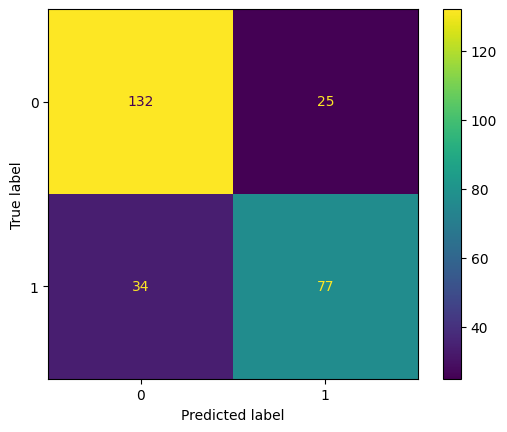

In [63]:
predict = classificador.predict(X_test)
accuracy = accuracy_score(y_test, predict)
cm = confusion_matrix(y_test, predict)
ConfusionMatrixDisplay(cm).plot()

$$ \Large Recal = \frac{TP}{TP + FN} $$

&nbsp;


$$ \Large Precision = \frac{TP}{TP + FP} $$

&nbsp;


$$ \Large F1 = 2 \cdot \frac{1}{\frac{1}{Precision} + \frac{1}{Recal}} $$

In [65]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       157
           1       0.75      0.69      0.72       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



https://www.youtube.com/watch?v=HZGCoVF3YvM